<a href="https://colab.research.google.com/github/Homabeyrami/ML-and-DL-Project/blob/main/BERT_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd, numpy as np
from tqdm.notebook import tqdm

#dimensionality reduction
!pip install umap-learn
from umap import UMAP
from sklearn.decomposition import PCA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
my_words_list1 = ['clean', 'unclean', 'dirty', 'filthy']

In [ ]:
!gdown --id 1fgqbG8lBCT007QDtZLw7VX6wGLsrb8yM #clean
!gdown --id 1lYtuPCSd04gV_DCAjIIcvqMOmMgjR3Ix #dirty
!gdown --id 1CDXzveVTbHW0iNfvHi8CA1cV4xwk6t1d #filthy
!gdown --id 1jRA6IxLVzDX1aH3gqYeSAGOK35hmx9bp #unclean

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fgqbG8lBCT007QDtZLw7VX6wGLsrb8yM
To: /content/Reza_clean.txt
100% 3.03k/3.03k [00:00<00:00, 12.3MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1lYtuPCSd04gV_DCAjIIcvqMOmMgjR3Ix
To: /content/Reza_dirty.txt
100% 4.13k/4.13k [00:00<00:00, 13.3MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https:

In [ ]:
clean_sent = pd.read_csv('Reza_clean.txt', header=None, names=["org_text"])
unclean_sent = pd.read_csv('Reza_unclean.txt', header=None, names=["org_text"])
filthy_sent = pd.read_csv('Reza_filthy.txt', header=None, names=["org_text"])
dirty_sent = pd.read_csv('Reza_dirty.txt', header=None, names=["org_text"])

In [ ]:
clean_sent = clean_sent.rename_axis('idx', axis='columns')
unclean_sent = unclean_sent.rename_axis('idx', axis='columns')
filthy_sent = filthy_sent.rename_axis('idx', axis='columns')
dirty_sent = dirty_sent.rename_axis('idx', axis='columns')

In [ ]:
df_list = pd.concat([clean_sent, unclean_sent, filthy_sent, dirty_sent], ignore_index=True, sort=False)

In [ ]:
labels = np.zeros(len(df_list))

## BERT Embedding

In [ ]:
# Embeddings
import torch
import transformers
from transformers import BertTokenizer, BertModel

In [ ]:
n_emb_base = 768
tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model (weights)
model_base = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
# Put the model in "evaluation" mode, meaning feed-forward operation.
model_base.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def getEmbedingBERT(text , desired_word_em, model, tokenizer, layer_num):
  # Run the text through BERT, and collect all of the hidden states produced

  # Convert inputs to PyTorch tensors
  # Mark each of the 22 tokens as belonging to sentence "1".
  marked_text = "[CLS] " + text + " [SEP]"

  # Split the sentence into tokens.
  tokenized_text = tokenizer.tokenize(marked_text)
  # Map the token strings to their vocabulary indeces.
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

  try:
    idx = np.where(np.array(tokenized_text) == desired_word_em)[0][0]
  except:
    print('except !!!!!!!!!!!!!!!!!!!', text)
    pass

  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  tokenized_text = tokenizer.tokenize(marked_text)
  with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)


    hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings[layer_num-1, idx, :]
    # bert_semcor_index.append(idx)
  return token_embeddings

In [ ]:
layer_num = 9

In [ ]:
#Semcor BERT embedding
emb_BERT_clean = np.zeros((len(clean_sent) , n_emb_base))
#extract bert_base embedding
for i in tqdm(range(len(clean_sent))):
  # text = remove_puncs(clean_sent.values[i][0])
  # text = text.lower()
  try:
    em = getEmbedingBERT(clean_sent.values[i][0], 'clean', model_base, tokenizer_base, layer_num)
    emb_BERT_clean[i] = em
    labels[i] = 0
  except:
    print('except ************')
    pass

idx_hold_base = np.where(np.sum(emb_BERT_clean, axis=1)!=0)[0]
emb_BERT_clean = emb_BERT_clean[idx_hold_base]
print(emb_BERT_clean.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 768)


In [ ]:
emb_BERT_unclean1 = np.zeros((len(unclean_sent) , n_emb_base))
#extract bert_base embedding
for i in tqdm(range(len(unclean_sent))):
  # text = remove_puncs(unclean_sent.values[i][0])
  # text = text.lower()
  try:
    em =   getEmbedingBERT(unclean_sent.values[i][0], 'uncle', model_base, tokenizer_base, layer_num)
    emb_BERT_unclean1[i] = em
    labels[i+50] = 1
  except:
    print('except ************')
    pass

idx_hold_base = np.where(np.sum(emb_BERT_unclean1, axis=1)!=0)[0]
emb_BERT_unclean1 = emb_BERT_unclean1[idx_hold_base]
print(emb_BERT_unclean1.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 768)


In [ ]:
emb_BERT_unclean2 = np.zeros((len(unclean_sent) , n_emb_base))
#extract bert_base embedding
for i in tqdm(range(len(unclean_sent))):
  # text = remove_puncs(unclean_sent.values[i][0])
  # text = text.lower()
  try:
    em =   getEmbedingBERT(unclean_sent.values[i][0], '##an', model_base, tokenizer_base, layer_num)
    emb_BERT_unclean2[i] = em

  except:
    print('except ************')
    pass

idx_hold_base = np.where(np.sum(emb_BERT_unclean2, axis=1)!=0)[0]
emb_BERT_unclean2 = emb_BERT_unclean2[idx_hold_base]
print(emb_BERT_unclean2.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 768)


In [ ]:
emb_BERT_unclean = np.mean((emb_BERT_unclean1, emb_BERT_unclean2), axis=0)

In [ ]:
emb_BERT_filthy = np.zeros((len(filthy_sent) , n_emb_base))
#extract bert_base embedding
for i in tqdm(range(len(filthy_sent))):
  # text = remove_puncs(filthy_sent.values[i][0])
  # text = text.lower()
  try:
    em =   getEmbedingBERT(filthy_sent.values[i][0], 'filthy', model_base, tokenizer_base, layer_num)
    emb_BERT_filthy[i] = em
    labels[i+100] = 2
  except:
    print('except ************')
    pass

idx_hold_base = np.where(np.sum(emb_BERT_filthy, axis=1)!=0)[0]
emb_BERT_filthy = emb_BERT_filthy[idx_hold_base]
print(emb_BERT_filthy.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 768)


In [ ]:
emb_BERT_dirty = np.zeros((len(dirty_sent) , n_emb_base))
#extract bert_base embedding
for i in tqdm(range(len(dirty_sent))):
  # text = remove_puncs(dirty_sent.values[i][0])
  # text = text.lower()
  try:
    em =   getEmbedingBERT(dirty_sent.values[i][0], 'dirty', model_base, tokenizer_base, layer_num)
    emb_BERT_dirty[i] = em
    labels[i+150] = 3

  except:
    print('except ************')
    pass

idx_hold_base = np.where(np.sum(emb_BERT_dirty, axis=1)!=0)[0]
emb_BERT_dirty = emb_BERT_dirty[idx_hold_base]
print(emb_BERT_dirty.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 768)


In [ ]:
BERT_emb_list = np.concatenate((emb_BERT_clean, emb_BERT_unclean, emb_BERT_filthy, emb_BERT_dirty))
df_list['Label'] = (labels.astype(int).tolist())

In [ ]:
#PCA setup
pca_2C_list = PCA(n_components=2, random_state=0)
pca_bert_2C_list = pca_2C_list.fit_transform(BERT_emb_list)

#UMAP setup
umap_2C_list = UMAP(n_components=2, n_neighbors=10, random_state=42)
umap_bert_2C_list = umap_2C_list.fit_transform(BERT_emb_list)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm_sc = MinMaxScaler()
pca_bert_2C_list = mm_sc.fit_transform(pca_bert_2C_list)
umap_bert_2C_list = mm_sc.fit_transform(umap_bert_2C_list)

In [ ]:
from sklearn.cluster import KMeans
n_clst_lst = 4
bert_kmeans_lst = KMeans(n_clusters=n_clst_lst, random_state=42)
kmeans_labels_bert_lst = bert_kmeans_lst.fit_predict(BERT_emb_list)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'PCA')

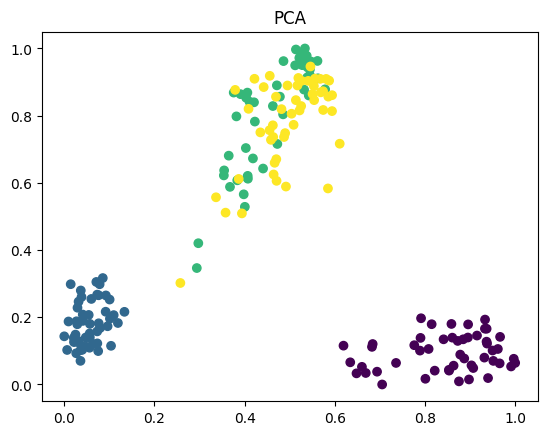

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(pca_bert_2C_list[:,0], pca_bert_2C_list[:,1], c=labels)
plt.title("PCA")

Text(0.5, 1.0, 'UMAP')

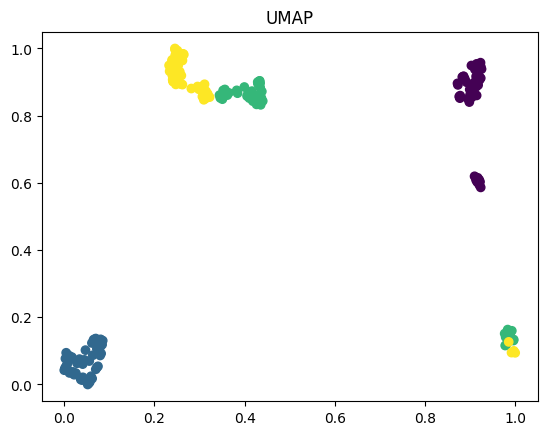

In [ ]:
plt.scatter(umap_bert_2C_list[:,0], umap_bert_2C_list[:,1], c=labels)
plt.title("UMAP")

In [ ]:
# Evaluate the clustering performance using the Silhouette Score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(BERT_emb_list, bert_kmeans_lst.labels_)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.2401999094064966
